# EDA

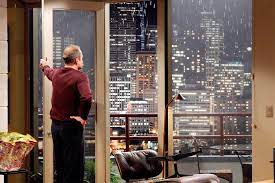

In [108]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
from scipy.stats import kde
from mpl_toolkits.mplot3d import Axes3D




from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# to be updated!
# -- main.py

# -- to be updated! create separate file ccleaning.py

#import pandas as pd  # only if you need it

#def clean_data(df):
    # put ALL your existing cleaning code in here
    # example:
#    df = df.dropna()
#    df = df.rename(columns={"old_name": "new_name"})
    # more cleaning steps...
#    return df


# -- to be updated! from cleaning import clean_data  # import from cleaning.py

#def main():
#    df = pd.read_csv('data/eda_project.csv')
#    df_clean = clean_data(df)    # call your cleaning function
#    print(df_clean.head())

#if __name__ == "__main__":
#    main()



df = pd.read_csv('data/eda_project.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

In [3]:
#cleaning data

# -- set default decimals to 2
pd.options.display.float_format = '{:.2f}'.format 

# -- set datetime type 
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


# -- clean values for yr_renovated NaN -> 0

# replace NaN with 0 and turn into dtype int. If not renovated: 0
df['yr_renovated'] = (
    pd.to_numeric(df['yr_renovated'], errors='coerce')  # convert invalid → NaN
      .fillna(0)                                        # replace NaN / inf
      .astype(int)                                     # convert to int
)

#divide by 10, ONE TIME ('19910' -> '1991')
#df['yr_renovated'] = (df['yr_renovated']/10)


# -- clean values for waterfront NaN -> 0
df['waterfront'] = (
    pd.to_numeric(df['waterfront'], errors='coerce')  # convert invalid → NaN
      .fillna(0)                                        # replace NaN / inf
      .astype(int)                                     # convert to int
)

# -- convert to int
df['bedrooms'] = df['bedrooms'].astype(int)





In [5]:
# create columns, definitions, etc needed to test hypotheses 1-3


# -- create column: True if ever a renovation was undertaken
df['status_renovated'] = (df['yr_renovated'] > 0)

# -- create columns: price/sqft_living & price/sqft_lot (pps = price-per-squarefootage)
df['pps_living'] = (df['price']/df['sqft_living'])
df['pps_lot'] = (df['price']/df['sqft_lot'])

# -- sort year order ascending
yr_order = sorted(df['yr_built'].unique())

# -- create bins for build year - code by CGPT
bins = list(range(1900, 2030, 10))
labels = [
    '1900s','10s','20s','30s',
    '40s','50s','60s','70s',
    '80s','90s','2000s','2010s'
]

df['yr_build_decade'] = pd.cut(
    df['yr_built'],
    bins=bins,
    labels=labels,
    right=False    
)


# -- define city vs rest of county relative to zipcode
# Some zipcodes pertain to more than one city/region. Here: city-only zipcodes defined as city
# Source: https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx

seattle_only_zip = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98109, 98111,
                98112, 98114, 98115, 98116, 98117,98118, 98119, 98121, 98122,
                98124, 98125, 98126, 98131, 98132, 98134, 98136, 98144, 98145,
                98154,98160, 98161, 98164, 98171, 98174, 98199
                ]

bellevue_only_zip = [98004, 98005, 98006, 98007, 98008, 98009, 98015
                    ]

kent_only_zip = [98030, 98031, 98032, 98035, 98042, 98064
                ]

renton_only_zip = [98055, 98056, 98057, 98058, 98059
                  ]

federalway_only_zip = [98001, 98003, 98023, 98063, 98093
                      ]


# king county without Seattle
kc_wo_seattle = [
                98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98009,
                98010, 98011, 98013, 98014, 98015, 98019, 98022, 98023, 98024,
                98025, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034,
                98035, 98038, 98039, 98040, 98041, 98042, 98045, 98047, 98050,
                98051, 98052, 98053, 98054, 98055, 98056, 98057, 98058, 98059,
                98062, 98063, 98064, 98065, 98068, 98070, 98071, 98072, 98073,
                98074, 98075, 98083, 98092, 98093, 98108, 98133, 98138, 98146,
                98148, 98155, 98158, 98166, 98168, 98177, 98178, 98188, 98198,
                98224, 98288, 98077
                ]

# zipcodes of places with population < 100K
kc_wo_cities = [98002, 98010, 98011, 98013, 98014, 98019, 98022, 98024, 98025,
                98027, 98028, 98029, 98033, 98034, 98038, 98039, 98040, 98041, 
                98045, 98047, 98050, 98051, 98052, 98053, 98054, 98062, 98065, 
                98068, 98070, 98071, 98072, 98073, 98074, 98075, 98083, 98092, 
                98224, 98288
               ]

# tbd! - king county zipcodes including seattle (not used here)
kc_total_zip = [98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98009, 
                98010, 98011, 98013, 98014, 98015, 98019, 98022, 98023, 98024, 
                98025, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 
                98035, 98038, 98039, 98040, 98041, 98042, 98045, 98047, 98050, 
                98051, 98052, 98053, 98054, 98055, 98056, 98057, 98058, 98059, 
                98062, 98063, 98064, 98065, 98068, 98070, 98071, 98072, 98073, 
                98074, 98075, 98083, 98092, 98093, 98101, 98102, 98103, 98104, 
                98105, 98106, 98107, 98108, 98109, 98111, 98112, 98114, 98115, 
                98116, 98117, 98118, 98119, 98121, 98122, 98124, 98125, 98126, 
                98131, 98132, 98133, 98134, 98136, 98138, 98144, 98145, 98146, 
                98148, 98154, 98155, 98158, 98160, 98161, 98164, 98166, 98168, 
                98171, 98174, 98177, 98178, 98188, 98198, 98199, 98224, 98288
                ]

# assign values based on zipcode lists
# nested np.where method works because zipcode lists are mutually exclusive
df['location_type'] = np.where(
    df['zipcode'].isin(seattle_only_zip),
    'Seattle',
    np.where( 
        df['zipcode'].isin(bellevue_only_zip),
        'Bellevue',
        np.where(
            df['zipcode'].isin(kent_only_zip),
            'Kent',
            np.where(
                df['zipcode'].isin(renton_only_zip),
                'Renton',
                np.where(
                    df['zipcode'].isin(federalway_only_zip),
                    'Federal Way',
                    np.where(
                        df['zipcode'].isin(kc_wo_seattle),
                        'King County without Cities',
                        'Outside King County' 
                    )
                )
            )
        )
    )
)
    
# order location_type as list
location_order = df.groupby('location_type')['pps_living'].mean().sort_values(ascending=False).index



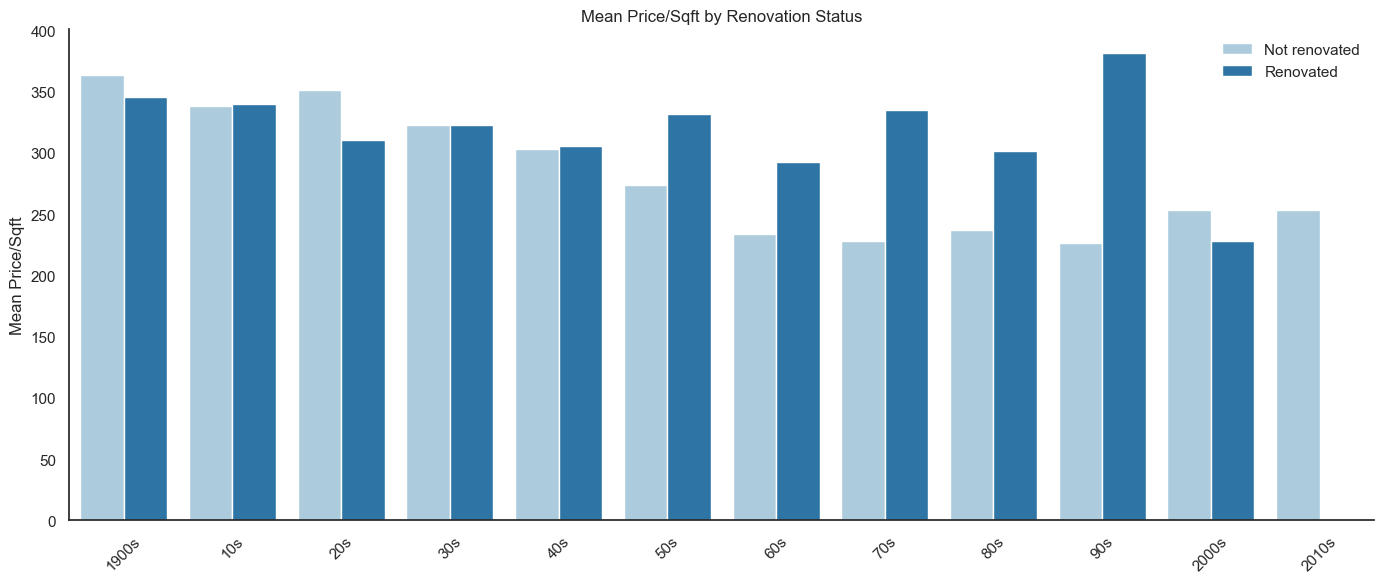

In [470]:
# Plot - Hypothesis 1
# "Renovated houses have a higher mean price/sqft than unrenovated houses built the same year."

# -- define final plot
plt.figure(figsize=(14, 6))

#sns.set_palette("Set2")
final_plot = sns.barplot(
    data=df,
    x='yr_build_decade',
    y='pps_living', # seaborn calculates mean
    hue='status_renovated',
    errorbar=None, #or 'sd' to show standard deviation errorbar
    #errwidth=0.5, #width of errorbar
    palette='Paired',
    saturation=0.8,
)


# -- text in plot
plt.xlabel(None)
plt.ylabel("Mean Price/Sqft")
plt.title("Mean Price/Sqft by Renovation Status")

# -- reduce ink
sns.despine()
plt.legend(labels=['Not renovated', 'Renovated'], title=None, frameon=False)

# -- print layout
plt.xticks(rotation=45) #turn labels on x-axis
plt.tight_layout()
plt.show()


In [264]:
# re Hypothesis 1
# -- high error margin 1990-1999 due to noisy sample: only 3 renovated houses in that bin.

check = (
    df[df['yr_build_decade'] == '1990–1999']
      .groupby('status_renovated')['pps_living']
      .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
)
print(check)


                  count   mean  median    std    min    max
status_renovated                                           
False              2229 226.51  215.79  81.37  97.04 790.82
True                  3 381.64  313.02 291.47 130.60 701.30


In [272]:
# re Hypothesis 1
# standard deviation not shown because renovated houses = 1. 
# dataset is from 2015. It is likely that very few houses needed renovation within 15 years after construction.
check = (
    df[df['yr_build_decade'] == '2000–2009']
      .groupby('status_renovated')['pps_living']
      .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
)
print(check)




                  count   mean  median   std    min    max
status_renovated                                          
False              3514 252.98  238.15 96.11  87.71 800.00
True                  1 227.90  227.90   NaN 227.90 227.90


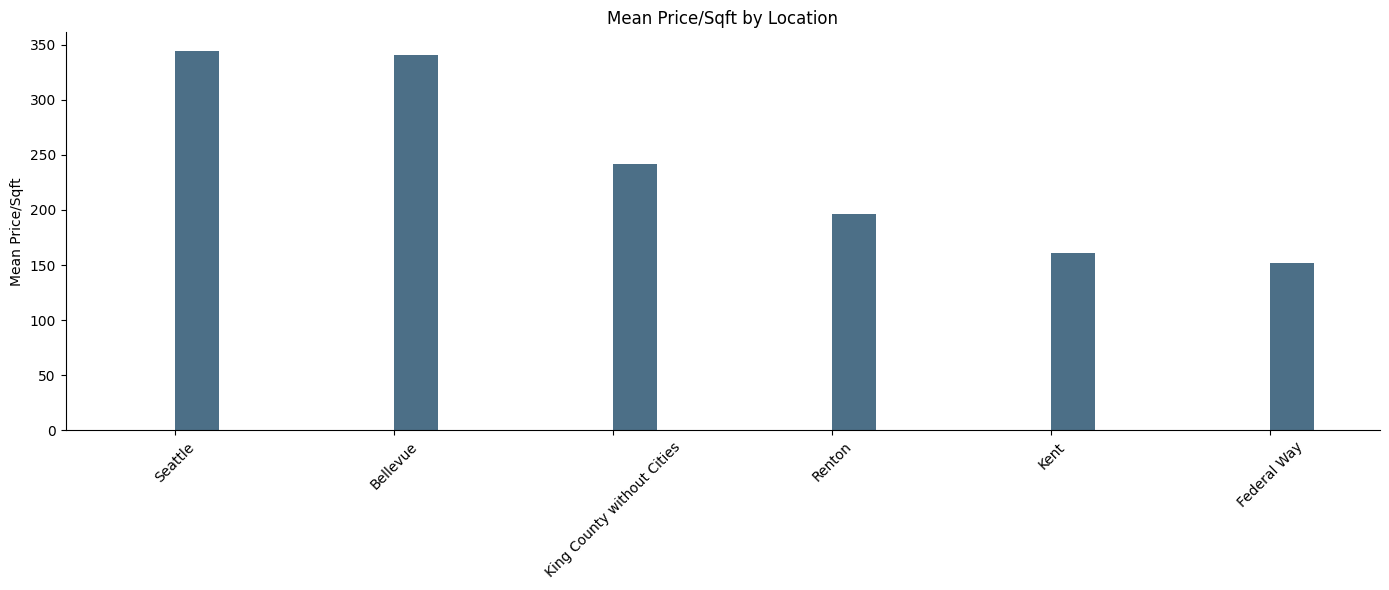

In [169]:
# plot re Hypothesis 2
# "Houses in Seattle have a higher mean price/sqft than houses in the rest of King County (by zip code)."


# -- define data final plot
plt.figure(figsize=(14, 6))

final_plot = sns.barplot(
    data=df,
    x='location_type',
    y='pps_living', # seaborn calculates mean
    order=location_order, #sorted by highest mean
    errorbar=None, #'sd' to show standard deviation errorbar
    #errwidth=0.5, #width of errorbar
    #palette='bright',
    saturation=0.4
)

# -- bar width and recenter - by cgpt
for bar in final_plot.patches:
    bar.set_width(0.2)

for bar in final_plot.patches:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + (1 - w) / 2)

# -- text in plot
plt.xlabel(None)
plt.ylabel("Mean Price/Sqft")
plt.title("Mean Price/Sqft by Location")

# -- remove top and right frame
sns.despine()

# -- plot design
plt.xticks(rotation=45) #turn labels on x-axis
plt.tight_layout()

# -- show plot
plt.show()





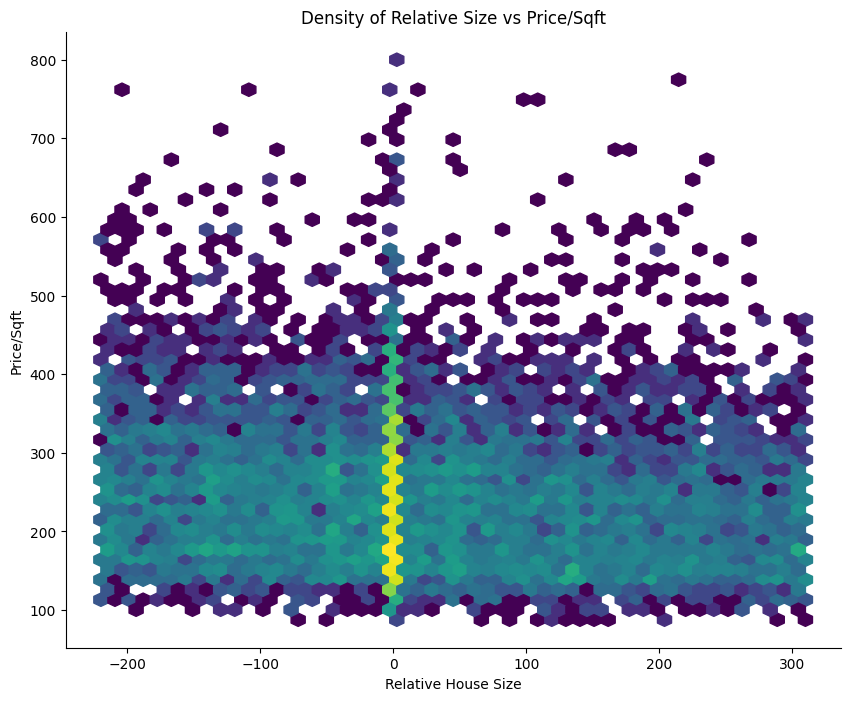

In [166]:
# plot re Hypothesis 3
# "When square footage of living space is greater than that of the neighbors, price/sqft is higher."
# in other words H3: "My house is more expensive if my neighbors have smaller houses -> my pps is higher."


# -- key variable :
# sqft_living = sqft_living15 in 12% of data (2563 rows)
# key variable a)
df['sqft_greater'] = df['sqft_living'] > df['sqft_living15']

# key variable b)
df['sqft_diff'] = df['sqft_living']-df['sqft_living15']

# key variable c) 
df['sqft_ratio'] = df['sqft_living']/df['sqft_living15']

# -- define data final plot

# use only IQR to reduce noise
# values from df.describe()
df_iqr = df[df['sqft_diff'].between(-220, 310)]

# -- plot
plt.figure(figsize=(10,8))
plt.hexbin(df_iqr['sqft_diff'], df_iqr['pps_living'], gridsize=50, bins='log')

# -- plot text 
#plt.colorbar(label='log(count)') #optional
plt.xlabel("Relative House Size")
plt.ylabel("Price/Sqft")
plt.title("Density of Relative Size vs Price/Sqft")

# -- reduce top and right frame
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)

# -- show plot
plt.show()



    

In [11]:
# re Hypothesis 3

# -- Pearson's r correlation
df[['sqft_ratio', 'pps_living']].corr()

,sqft_ratio,pps_living
sqft_ratio,1.00,-0.22
pps_living,-0.22,1.00


In [111]:
# re Hypothesis 3 - by cgpt

# -- Check how many properties have identical values
identical_count = (df['sqft_living'] == df['sqft_living15']).sum()
total_count = len(df)
percentage = (identical_count / total_count) * 100

print(f"Identical values: {identical_count} out of {total_count}")
print(f"Percentage: {percentage:.2f}%")

# -- Look at some examples
print("\nExamples where sqft_living == sqft_living15:")
print(df[df['sqft_living'] == df['sqft_living15']][['sqft_living', 'sqft_living15', 'zipcode', 'lat', 'long']].head(10))

Identical values: 2563 out of 21597
Percentage: 11.87%

Examples where sqft_living == sqft_living15:
    sqft_living  sqft_living15  zipcode    lat     long
8      1780.000       1780.000    98146 47.512 -122.337
13     1370.000       1370.000    98074 47.613 -122.045
16     1890.000       1890.000    98019 47.728 -121.962
28     1520.000       1520.000    98115 47.695 -122.304
39     2620.000       2620.000    98056 47.530 -122.180
50     1190.000       1190.000    98148 47.426 -122.322
52     1410.000       1410.000    98117 47.681 -122.384
54     2730.000       2730.000    98105 47.657 -122.281
56     2250.000       2250.000    98042 47.366 -122.114
80     2350.000       2350.000    98038 47.351 -122.008


In [120]:
# re Hypothesis 3 - by cgpt

# -- Check if matches cluster by location
matches = df[df['sqft_living'] == df['sqft_living15']]
no_matches = df[df['sqft_living'] != df['sqft_living15']]

print("Matches by zipcode:")
print(matches['zipcode'].value_counts().head(20))

print("\nMatches by decade built:")
print(matches['yr_build_decade'].value_counts())

# -- Check if these are in developments
print("\nAverage sqft_living for matches:", matches['sqft_living'].mean())
print("Average sqft_living for non-matches:", no_matches['sqft_living'].mean())

Matches by zipcode:
zipcode
98038    105
98103     89
98042     87
98052     72
98133     68
98115     64
98059     63
98053     62
98023     61
98117     59
98126     57
98029     56
98065     56
98034     55
98033     54
98031     54
98074     54
98075     53
98056     53
98106     53
Name: count, dtype: int64

Matches by decade built:
yr_build_decade
2000s    679
90s      322
60s      254
70s      250
2010s    243
80s      231
50s      216
40s      147
20s       92
10s       53
1900s     44
30s       32
Name: count, dtype: int64

Average sqft_living for matches: 1924.8591494342568
Average sqft_living for non-matches: 2101.2554901754756
